# Calibrating Quicksurvey using Gaussian Mixture Models

The goal of this notebook is to use noiseless spectroscopic simulations from `desitarget.select_mock_targets` to calibrate a set of Gaussian mixture models (GMMs) which can be used in turn to simulate much larger datasets just at the catalog level, i.e., *quicksurvey*.

In [24]:
import os
import warnings
import numpy as np
from pkg_resources import resource_filename

In [25]:
from astropy.table import Table
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split

In [26]:
from desiutil.sklearn import GaussianMixtureModel
from desitarget.targetmask import desi_mask

In [27]:
import matplotlib.pyplot as plt
import corner as cn

In [28]:
%matplotlib inline

#### Simulation variables

In [29]:
seed = 1
rand = np.random.RandomState(seed)
overwrite = True

### Define some convenience functions for doing the Gaussian mixture modeling.

In [30]:
def get_mog_bic(X, ncomp, rand=None):
    """Compute the MoG and BIC for a range of Gaussian components."""
    mog = [GMM(n_components=nc, random_state=rand).fit(X) for nc in ncomp]
    bic = [_mog.bic(X) for _mog in mog]
    return mog, np.array(bic)

In [31]:
def qa_bic(ncomp, bic, title='Object', png=None):
    ncompbest = ncomp[np.argmin(bic)]
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(ncomp, bic / 100, marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion / 100')
    ax.set_title('{}: Optimal number of components = {:d}'.format(title, ncompbest))
    if png:
        plt.savefig(png)

In [32]:
def build_gmm(X, ncompmin=1, ncompmax=5, target='', 
              rand=None, png=None, overwrite=False):
    """Find the optimal GMM."""

    if rand is None:
        rand = np.random.RandomState()
    ncomp = np.arange(ncompmin, ncompmax)

    gmmfile = resource_filename('desitarget', 'mock/data/quicksurvey_gmm_{}.fits'.format(
        target.lower()))
    if ~os.path.isfile(gmmfile) or overwrite:
        print('Generating a GMM for {}s with N={}-{} components from {} objects.'.format(
            target, ncompmin, ncompmax, X.shape[0]))
        allmog, bic = get_mog_bic(X, ncomp, rand=rand)
        qa_bic(ncomp, bic, png=png, title=target)    
    
        print('Writing {}'.format(gmmfile))
        mog = allmog[np.argmin(bic)] # minimize the BIC
        GaussianMixtureModel.save(mog, gmmfile)

    # (Re)read the model to get a few more convenience methods.
    print('Reading {}'.format(gmmfile))
    mog = GaussianMixtureModel.load(gmmfile)

    return mog

### Read the reference truth catalog.

In [39]:
def read_targets_truth():
    refdir = os.path.join(os.getenv('DESI_ROOT'), 'datachallenge', 
                          'reference_runs', '18.3', 'targets')
    truthfile = os.path.join(refdir, 'truth.fits')
    targetsfile = os.path.join(refdir, 'targets.fits')

    truth = Table.read(truthfile).to_pandas()
    print('Read {} objects from {}'.format(len(truth), truthfile))

    targets = Table.read(targetsfile).to_pandas()
    print('Read {} objects from {}'.format(len(targets), targetsfile))
    
    return targets, truth

In [41]:
targets, truth = read_targets_truth()
targets.head()

Read 240902 objects from /Users/ioannis/work/desi/datachallenge/reference_runs/18.3/targets/truth.fits
Read 240902 objects from /Users/ioannis/work/desi/datachallenge/reference_runs/18.3/targets/targets.fits


,BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,...,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SUBPRIORITY,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL
0,5261,1526p282,0,152.762924,28.312584,4.874188,12.402152,21.592880,16.472528,10.947385,...,0.000594,0.452496,0.001006,-0.001022,0.356810,288230398217945088,1152921504606846976,65537,0,0
1,5261,1524p280,1,152.563858,28.102776,21.616667,37.297195,55.960228,51.405430,38.105453,...,-0.000685,0.866786,-0.106927,-0.023011,0.568604,288230398217945089,1152921504606846976,131074,0,0
2,5261,1526p285,2,152.636505,28.547132,18.822695,48.336021,84.638054,76.405373,51.429577,...,-0.088905,0.393993,-0.256706,-0.010039,0.932925,288230398217945090,1152921504606846976,131074,0,0
3,5261,1523p282,3,152.453033,28.322897,17.327436,69.110542,146.391541,176.066605,125.939812,...,-0.170571,-0.000192,-0.003329,-0.003309,0.588079,288230398217945091,1152921504606846976,131074,0,0
4,5261,1529p282,4,152.821365,28.337770,1.970049,9.621946,21.381821,35.962608,27.767466,...,0.000594,1.116037,0.119471,-0.221381,0.175434,288230398217945092,1152921504606846976,65537,0,0


In [42]:
truth.head()

,TARGETID,MOCKID,CONTAM_TARGET,TRUEZ,TRUESPECTYPE,TEMPLATETYPE,TEMPLATESUBTYPE,TEMPLATEID,SEED,MAG,...,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,OIIFLUX,HBETAFLUX,TEFF,LOGG,FEH
0,288230398217945088,15594312,0,0.134829,GALAXY,BGS,,3627,1482857632,19.810371,...,5.244956,13.027136,22.072302,17.045567,11.077766,-1.0,0.000000e+00,-1.0,-1.0,-1.0
1,288230398217945089,19713506,0,0.131031,GALAXY,BGS,,3100,1847516324,18.553574,...,23.236532,39.164349,57.429871,52.143738,38.030403,-1.0,1.624847e-15,-1.0,-1.0,-1.0
2,288230398217945090,17928726,0,0.145801,GALAXY,BGS,,1281,1159188526,18.351431,...,19.850098,50.108429,86.518089,74.636200,51.438339,-1.0,0.000000e+00,-1.0,-1.0,-1.0
3,288230398217945091,19762079,0,0.295097,GALAXY,BGS,,5168,1664239784,17.993166,...,18.452414,71.998535,149.989059,178.461807,126.496735,-1.0,0.000000e+00,-1.0,-1.0,-1.0
4,288230398217945092,13979089,0,0.404595,GALAXY,BGS,,6077,236582212,20.154673,...,2.099783,9.958090,21.838903,36.395954,28.041195,-1.0,0.000000e+00,-1.0,-1.0,-1.0


### Define some wrapper functions for reading the data and generating QA.

In [62]:
def get_data(target='ELG', dataframe=False):
    """Build the data matrix."""
    from desitarget.targetmask import desi_mask, mws_mask, bgs_mask
    
    if target == 'LYA':
        indx = ( (targets['DESI_TARGET'].values & desi_mask.QSO != 0) & 
                 (truth['TEMPLATESUBTYPE'].str.contains('LYA')) )
    else:
        if 'MWS' in target:
            indx = ( (targets['MWS_TARGET'].values & mws_mask.mask(target)) != 0 &
                    (truth['TEMPLATETYPE'].str.contains('STAR')) )
        elif 'BGS' in target:
            indx = ( (targets['DESI_TARGET'].values & desi_mask.BGS_ANY) != 0 &
                    (truth['TEMPLATETYPE'].str.contains('GALAXY')) )
        else:
            if target == 'QSO':
                indx = ( (targets['DESI_TARGET'].values & desi_mask.mask(target)) != 0 & 
                        (truth['TEMPLATETYPE'].str.contains('QSO')) )
            else:
                indx = ( (targets['DESI_TARGET'].values & desi_mask.mask(target)) != 0 & 
                        (truth['TEMPLATETYPE'].str.contains('GALAXY')) )

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        gmag = 22.5 - 2.5 * np.log10(truth['FLUX_G'].values[indx])
        rmag = 22.5 - 2.5 * np.log10(truth['FLUX_R'].values[indx])
        zmag = 22.5 - 2.5 * np.log10(truth['FLUX_Z'].values[indx])
        gr = - 2.5 * np.log10(truth['FLUX_G'].values[indx] / truth['FLUX_R'].values[indx])
        rz = - 2.5 * np.log10(truth['FLUX_R'].values[indx] / truth['FLUX_Z'].values[indx])
        zW1 = - 2.5 * np.log10(truth['FLUX_Z'].values[indx] / truth['FLUX_W1'].values[indx])
        W1W2 = - 2.5 * np.log10(truth['FLUX_W1'].values[indx] / truth['FLUX_W2'].values[indx])
        oii = np.log10(1e17 * truth['OIIFLUX'].values[indx])
        
    if dataframe:
        import pandas as pd
        df = pd.DataFrame()
        df['g - r'] = gr
        df['r - z'] = rz
        df['z - W1'] = zW1
        df['W1 - W2'] = W1W2
        if target == 'ELG':
            df['r'] = rmag
            df['[OII]'] = oii
        elif target == 'LRG':
            df['z'] = zmag
        elif target == 'QSO' or target == 'LYA':
            df['g'] = gmag
        return df
    else:
        nobj = len(indx)
        X = np.vstack( (gr, rz, zW1, W1W2) )
        if target == 'ELG':
            X = np.vstack( (rmag, X, oii) )
        elif target == 'LRG':
            X = np.vstack( (zmag, X) )
        elif target == 'QSO':
            X = np.vstack( (gmag, X) )
        elif target == 'LYA':
            X = np.vstack( (gmag, X) )

        return X.T

In [35]:
def qa_corner(Xdata, Xsample, target=''):
    if target == 'ELG':
        labels = ('r', 'g - r', 'r - z', 'z - W1', 'W1 - W2', r'log$_{10}$ [OII]-17')
    elif target == 'LRG':
        labels = ('z', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    elif target == 'QSO':
        labels = ('g', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    elif target == 'LYA':
        labels = ('g', 'g - r', 'r - z', 'z - W1', 'W1 - W2')
    
    fig = cn.corner(Xdata, labels=labels, label_kwargs={"fontsize": 14}, 
                    show_titles=True, title_kwargs={"fontsize": 12},
                    color='k')
    fig.suptitle('{} Validation Data (grayscale) + GMM Samples (green points)'.format(target.upper()))
    
    nobj, ndim = Xdata.shape
    axes = np.array(fig.axes).reshape((ndim, ndim))
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.scatter(Xsample[:, xi], Xsample[:, yi], marker='s', 
                       color='g', s=5, alpha=0.5)

In [36]:
def train_and_validate(target, Nsample=500, overwrite=False):
    X = get_data(target.upper())
    Xtrain, Xvalidate = train_test_split(X, test_size=0.5, random_state=rand)
    
    mog = build_gmm(Xtrain, ncompmin=3, ncompmax=50, overwrite=overwrite, 
                    target=target, rand=rand, png=None)
    
    Xsample = mog.sample(Nsample, random_state=rand)
    qa_corner(Xvalidate, Xsample, target=target)
    
    return mog

### LYAs
Train a GMM on *g*, *g-r*, *r-z*, *z-W1*, and *W1-W2*.

Generating a GMM for LYAs with N=3-50 components from 1044 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lya.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lya.fits
CPU times: user 1min 2s, sys: 745 ms, total: 1min 3s
Wall time: 17.2 s


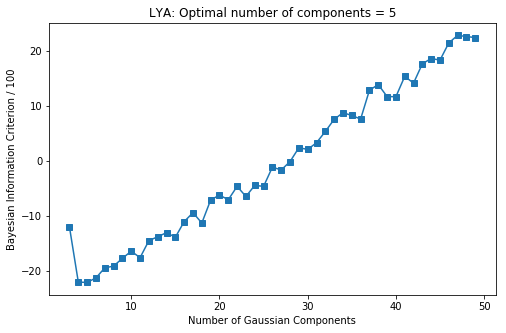

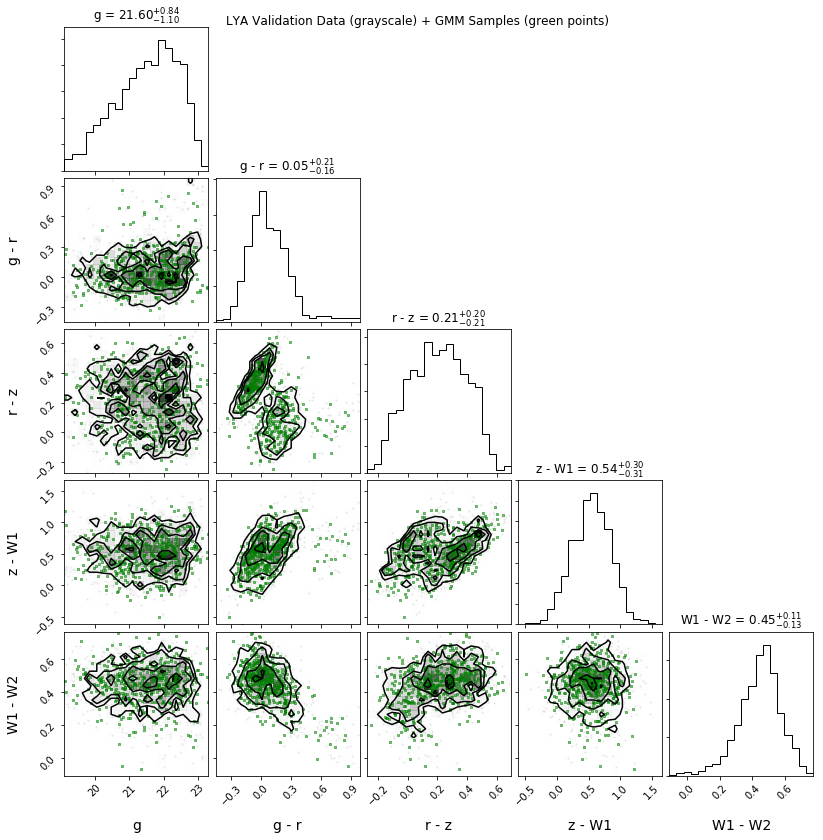

In [60]:
%time mog = train_and_validate('LYA', Nsample=500, overwrite=overwrite)

### QSOs

Train a GMM on *g*, *g-r*, *r-z*, *z-W1*, and *W1-W2*.

Generating a GMM for QSOs with N=3-50 components from 3444 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_qso.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_qso.fits
CPU times: user 2min 5s, sys: 1.39 s, total: 2min 6s
Wall time: 32.8 s


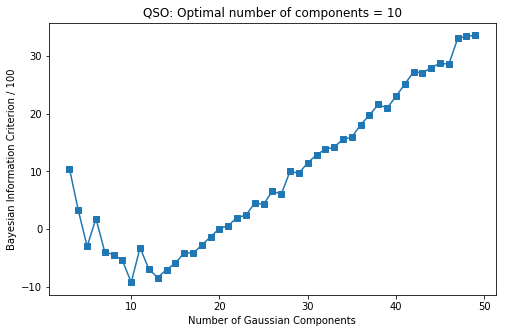

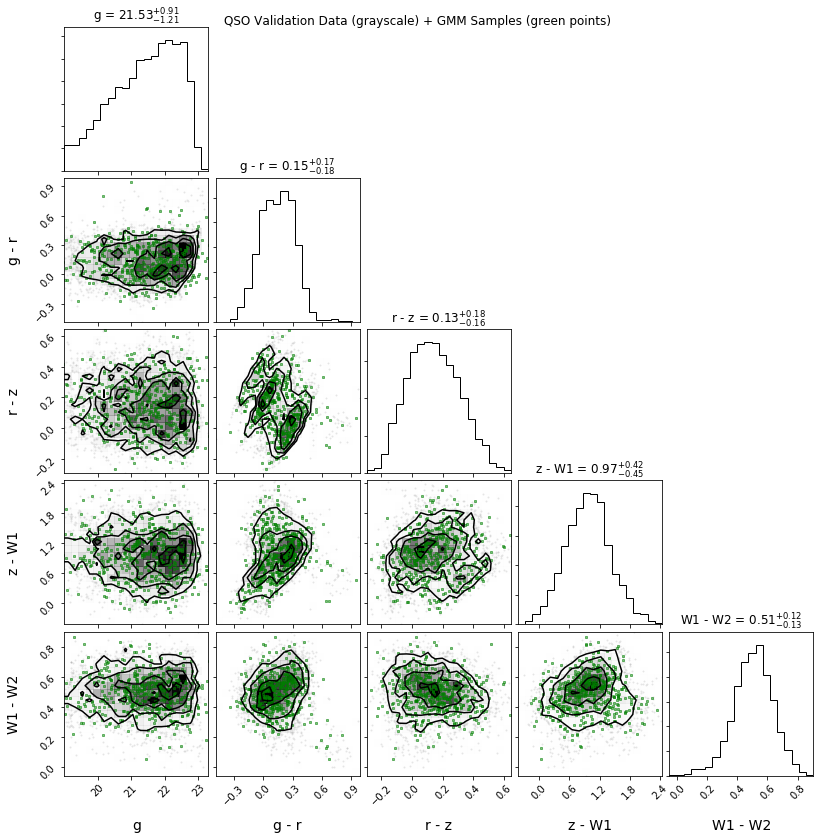

In [38]:
%time mog = train_and_validate('QSO', Nsample=500, overwrite=overwrite)

### LRGs

Train a GMM on *z*, *g-r*, *r-z*, *z-W1*, and *W1-W2*.

Generating a GMM for LRGs with N=3-50 components from 7721 objects.
Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lrg.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_lrg.fits
CPU times: user 5min 11s, sys: 9.09 s, total: 5min 20s
Wall time: 1min 21s


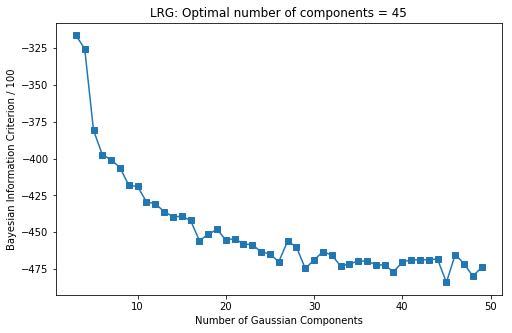

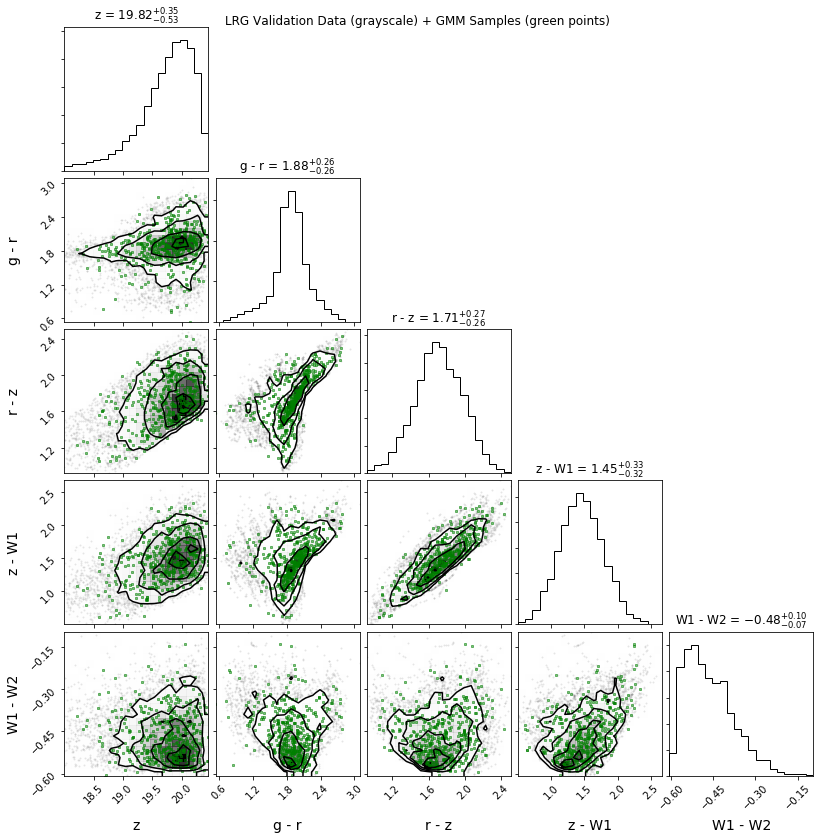

In [15]:
%time mog = train_and_validate('LRG', Nsample=500, overwrite=overwrite)

### ELGs

Train a GMM on *r*, *g-r*, *r-z*, *z-W1*, *W1-W2*, and *[OII] flux*.

Generating a GMM for ELGs with N=3-50 components from 40752 objects.


/usr/local/anaconda3/envs/desi/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Writing /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_elg.fits
Reading /Users/ioannis/repos/desihub/desitarget/py/desitarget/mock/data/quicksurvey_gmm_elg.fits
CPU times: user 41min 22s, sys: 1min 42s, total: 43min 4s
Wall time: 10min 58s


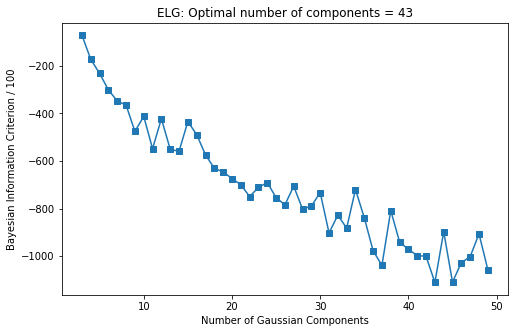

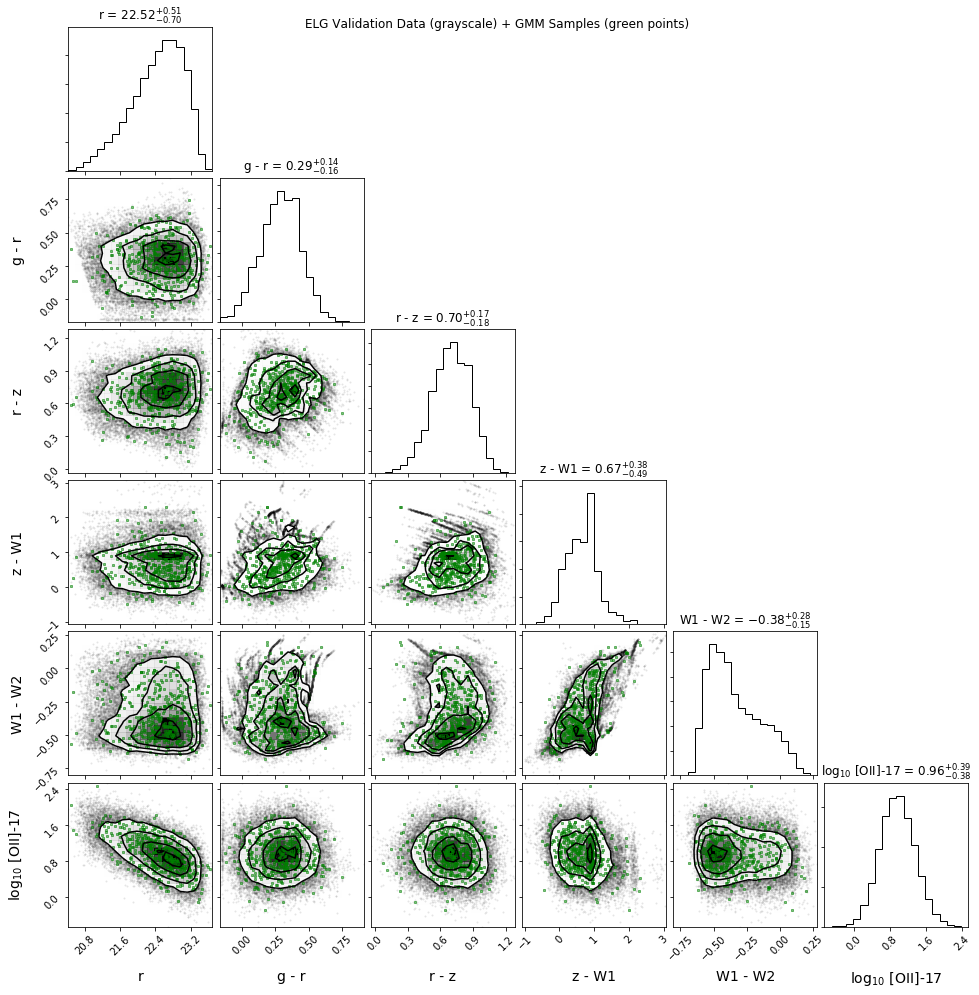

In [17]:
%time mog = train_and_validate('ELG', Nsample=500, overwrite=overwrite)